Let's start by reproducing some results of Quilee's notebook in _CElegansNeuralPrediction.ipynb_

# Fixing train/_main.py
---

It looks like the dataset returned after running `get_dataset()` doesn't have the "worm" keys.

In [1]:
# All imports for train module
import torch
import os
import hydra
import random
import time
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from scipy.linalg import solve
from typing import Tuple, Union
from datetime import datetime
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig
from omegaconf import OmegaConf
from utils import DEVICE, LOGS_DIR, NEURONS_302
from tqdm import tqdm
from torch.utils.data.dataloader import default_collate
from torch.utils.data import ConcatDataset, DataLoader
from models._utils import NetworkLSTM
from data._utils import NeuralActivityDataset, pick_worm
from data._main import get_dataset
from models._main import get_model
from scipy.signal import savgol_filter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
config = OmegaConf.load("../../conf/train.yaml")
print("config:", OmegaConf.to_yaml(config))

config: train:
  optimizer: AdamW
  learn_rate: 0.01
  epochs: 1
  save_freq: 100
  seq_len: 100
  k_splits: 2
  num_samples: 16
  num_batches: 1
  tau_in: 1
  shuffle: false
  reverse: false



In [4]:
model = get_model(OmegaConf.load("../../conf/model.yaml"))

Initialized a new model.

Model: LinearNN(
  (identity): Identity()
  (linear): Linear(in_features=512, out_features=302, bias=True)
  (model): Sequential(
    (0): Linear(in_features=302, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=512, out_features=302, bias=True)
  )
)



In [73]:
dataset = get_dataset(OmegaConf.load("../../conf/dataset.yaml"))

Chosen dataset(s): ['Nguyen2017']
Num. worms: 3



Let's take a look inside it

In [74]:
dataset['worm0'].keys()

dict_keys(['dataset', 'smooth_method', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', 'max_timesteps', 'time_in_seconds', 'dt', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons', 'named_neurons_mask', 'unknown_neurons_mask', 'neurons_mask', 'slot_to_named_neuron', 'named_neuron_to_slot', 'slot_to_unknown_neuron', 'unknown_neuron_to_slot', 'slot_to_neuron', 'neuron_to_slot'])

In [75]:
len(dataset)

3

In [76]:
features = []

for ds in dataset:
    features.append(list(dataset[ds].keys()))

features = np.unique(np.concatenate(features))

for ds in dataset:
    for f in features:
        if f not in dataset[ds].keys():
            print(dataset[ds]['dataset'])

All datasets have the same features (verifying)

In [77]:
len(sorted(features))

22

In [78]:
len((sorted(dataset.items())*2))

6

In [79]:
# Cycle the dataset until the desired number epochs obtained
train_epochs = 2
num_unique_worms = len(dataset)

dataset_items = sorted(dataset.items()) * train_epochs
assert (
    len(dataset_items) == train_epochs * num_unique_worms
), "Invalid number of worms."

for item in dataset_items:
    print(item[0], end=' ')

print('\n')

# Shuffle (without replacement) the worms (including duplicates) in the dataset
dataset_items = random.sample(dataset_items, k=len(dataset_items))

for item in dataset_items:
    print(item[0], end=' ')

worm0 worm1 worm2 worm0 worm1 worm2 

worm2 worm2 worm0 worm0 worm1 worm1 

In [80]:
sorted?

Signature: sorted(iterable, /, *, key=None, reverse=False)
Docstring:
Return a new list containing all items from the iterable in ascending order.

A custom key function can be supplied to customize the sort order, and the
reverse flag can be set to request the result in descending order.
Type:      builtin_function_or_method

In [81]:
len(dataset_items)

6

In [82]:
worm_cohorts = np.array_split(dataset_items, train_epochs)
worm_cohorts

[array([['worm2',
         {'dataset': 'Nguyen2017', 'smooth_method': 'FFT', 'worm': 'worm2', 'calcium_data': tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.2563,  0.0000],
                 [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.2563,  0.0000],
                 [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.2694,  0.0000],
                 ...,
                 [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.5321,  0.0000],
                 [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.4843,  0.0000],
                 [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.3278,  0.0000]]), 'smooth_calcium_data': tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.1523,  0.0000],
                 [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0820,  0.0000],
                 [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0134,  0.0000],
                 ...,
                 [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.3439,  0.0000],
                 [ 0.0000,  0.0000,  0.0000,  ...

In [83]:
worm_cohorts = [_.tolist() for _ in worm_cohorts]  # convert cohort arrays to lists
worm_cohorts

[[['worm2',
   {'dataset': 'Nguyen2017',
    'smooth_method': 'FFT',
    'worm': 'worm2',
    'calcium_data': tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.2563,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.2563,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.2694,  0.0000],
            ...,
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.5321,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.4843,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.3278,  0.0000]]),
    'smooth_calcium_data': tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.1523,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0820,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0134,  0.0000],
            ...,
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.3439,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.2860,  0.0000],
            [ 0.0000,

In [84]:
worm_cohorts[0][2]

['worm0',
 {'dataset': 'Nguyen2017',
  'smooth_method': 'FFT',
  'worm': 'worm0',
  'calcium_data': tensor([[ 0.1733,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.3249,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.4766,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.6086,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.6079,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.6121,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
  'smooth_calcium_data': tensor([[-0.0146,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.1183,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.2493,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.3839,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.2695,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.1452,  0.0000,  0.0000,  ...,  0.0000,  0

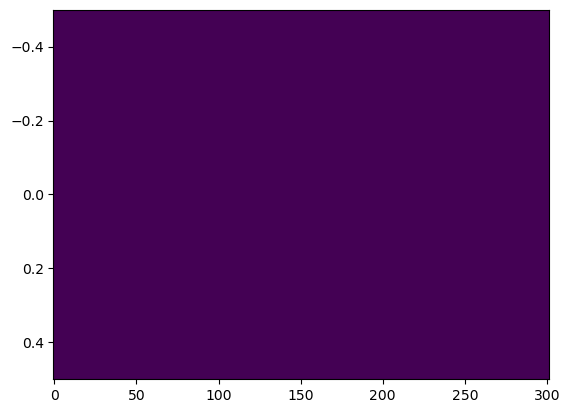

In [85]:
from matplotlib import pyplot as plt
plt.imshow(dataset['worm0']['named_neurons_mask'].reshape(1,-1), aspect='auto')

In [88]:
for i, cohort in enumerate(worm_cohorts):

        # Iterate over each worm in the cohort
        for j, (worm, single_worm_dataset) in enumerate(cohort):
                print(single_worm_dataset.keys())

dict_keys(['dataset', 'smooth_method', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', 'max_timesteps', 'time_in_seconds', 'dt', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons', 'named_neurons_mask', 'unknown_neurons_mask', 'neurons_mask', 'slot_to_named_neuron', 'named_neuron_to_slot', 'slot_to_unknown_neuron', 'unknown_neuron_to_slot', 'slot_to_neuron', 'neuron_to_slot'])
dict_keys(['dataset', 'smooth_method', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', 'max_timesteps', 'time_in_seconds', 'dt', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons', 'named_neurons_mask', 'unknown_neurons_mask', 'neurons_mask', 'slot_to_named_neuron', 'named_neuron_to_slot', 'slot_to_unknown_neuron', 'unknown_neuron_to_slot', 'slot_to_neuron', 'neuron_to_slot'])
dict_keys(['dataset', 'smooth_method', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', '

In [93]:
a = dataset.setdefault("train_mask", 123)
dataset['train_mask']

123

# The Datasets
---

The dataset consists of calcium imaging data from our worm

|Paper Link             |Database Link     |Files w/ Data          |Num. ID'd| 
|-----------------------|------------------|-----------------------|---------|
|tinyurl.com/Uzel2022   |osf.io/3vkxn/     |`Uzel_WT.mat`          |54/154   |
|tinyurl.com/Kaplan20   |osf.io/9nfhz/     |`Neuron2019_Data_*.mat`|48/103   |
|tinyurl.com/Nguyen17   |tinyurl.com/LeiferIEEE|`heatData*.mat`    |0/156    | 
|tinyurl.com/Skora2018  |osf.io/za3gt/     |`WT_*.mat`             |40/139   |
|tinyurl.com/Nichols2017|osf.io/kbf38/     |`*let.mat`             |35/116   |
|tinyurl.com/Kato2015   |osf.io/2395t/     |`WT_*Stim.mat`         |38/109   |

To load the datasets we can use the functions in `data/_utilis.py`

In [4]:
from data._utils import load_dataset, pick_worm, find_reliable_neurons

In [5]:
# load a dataset
Nguyen2017 = load_dataset("Nguyen2017")
print(Nguyen2017.keys())
print(Nguyen2017['worm0'].keys())
print(Nguyen2017['worm0']['calcium_data'].shape)

dict_keys(['worm0', 'worm1', 'worm2'])
dict_keys(['dataset', 'smooth_method', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', 'max_timesteps', 'time_in_seconds', 'dt', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons', 'named_neurons_mask', 'unknown_neurons_mask', 'neurons_mask', 'slot_to_named_neuron', 'named_neuron_to_slot', 'slot_to_unknown_neuron', 'unknown_neuron_to_slot', 'slot_to_neuron', 'neuron_to_slot'])
torch.Size([3044, 302])


So we have a hierarchy to access the data of each worm in the dataset:
 - First the choosen worm
 - Second the dataset itself with its features and other informations (note that the key `dataset` corresponds to the name of the dataset and not to the raw data or something like that)

In [6]:
'worm2' in set(Nguyen2017.keys())

True

In [7]:
wormid = np.random.choice(list(Nguyen2017.keys()))
single_worm_dataset = pick_worm(Nguyen2017, wormid)

KeyError: 'generator'